<a href="https://colab.research.google.com/github/lbattioni/DS_coder_house/blob/main/Luciano_Battioni_DSIII_TP_final_Redes_neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Presentación del Proyecto

> Añadir blockquote



## Abstracto

Las mediciones automáticas de ecocardiogramas están disponibles en equipos de alta gamma. Estas mediciones han demostrado disminuir el tiempo requerido para la realización del examen y el reporte. De esta manera tanto profesionales como pacientes se benefician de tiempos de espera más cortos. Sin embargo, estos equipos son mucho más costosos y no son accesibles a la mayoria de los profesionales.
El objetivo del presente estudio es elaborar un modelo que permita realizar mediciones en base a las imágenes del reporte.

## Contexto comercial y analítico

El ecocardiograma es una herramienta fundamental en la cardiología actual. Mediante el uso de ventanas ultrasónicas estandarizadas se pueden observar las estructuras internas del corazón y su paredes. De esta manera determinar a través de distinas mediciones y observación directa la presencia de patologías.

El eje largo para esternal es, la mayoría de las veces, la primera ventana interrogada. En esta observamos y medimos las dimensiones del ventrículo izquierdo y el espesor de sus paredes.
En un óptimo eje largo para esternal las paredes tienen un claro contraste con la cavidad, habiando un fuerte contraste entre lo hipoecoico de la sangra intra ventricular y lo iso ecogénico de las paredes ventriculares, este contraste debería permitir la identificación de contraste y en consecuencia de los espesores y dimensiones del ventrículo izquierdo en el eje largo para esternal.
Este medición es básica y fundamental en cualquier estudio ecocardiográfico ya que deterimina la presencia de dilatación ventricular e/o hipertrofia (estados patológicos).

Las mediciones automáticas, ya disponibles en ciertos equipos de alta gamma, disminuyen el tiempo de examen y de generación de reporte, lo que beneficiaría a los operadores que realizan los exámenes y a los pacientes que frecuentemente esperan meses para realizarce este estudio.

La generación de modulo de mediciones automáticas en base a las imágenes capturadas permitiría acceso a estas herramientas a usuarios con menor capacidad económica.

## Hipótesis y Objetivo

Generar un modelo de redes CNN que permita medir el septum interventricular (SIV), diámetro diastólico del ventrículo izquierdo (DDVI) y pared posterior del ventrículo izquierdo (PP)

# Obtención de datos
Las imágenes y las medidas Target se encuentran en la carpeta publica portfolio,que permanecera abierta hasta el primero de diciembre. Luego por cuestiones de almacenamiento será borrada.
## Librerías

In [ ]:
#importancion de paquetes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from pathlib import Path
import os.path
from PIL import Image
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import mean_absolute_error
from tensorflow.keras import regularizers
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyyaml h5py

In [ ]:
#cargar imagenes
image_dir=Path('/content/drive/MyDrive/portfolio/trabajo final borrador/2022-11-19')
filepaths=pd.Series(list(image_dir.glob('**/*.png')),name='filepath').astype(str)

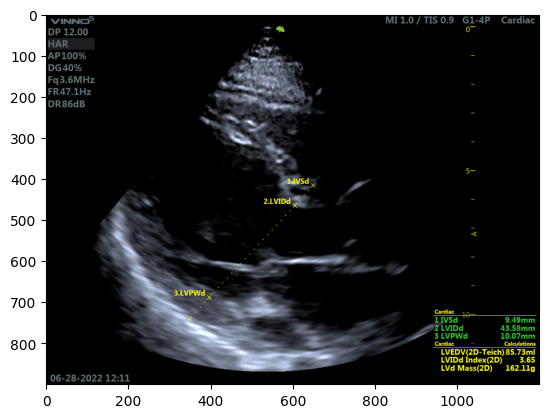

In [ ]:
#muestro imagen original
sample_pre_crop=Image.open(filepaths[0])
plt.imshow(sample_pre_crop)

In [ ]:
#genero una lista y un array con las imágenes y dato tipo float 32, lo normalizo y paso a RGB
def center_crop(image, target_size):
    width, height = image.size
    new_side = min(width, height)  # El menor tamano posible
    left = (width - new_side) / 2
    top = (height - new_side) / 2
    right = (width + new_side) / 2
    bottom = (height + new_side) / 2
    return image.crop((left, top, right, bottom))
im=[]
for i in filepaths:
    pre_crop=Image.open(i)
    crop=center_crop(pre_crop, target_size=(900, 800))
    crop=crop.convert('RGB')  # convierto RGBA a RGB
    crop = crop.resize((224, 224))
    crop=np.array(crop).astype(np.float32) / 255.0
    im.append(crop)
im_array=np.array(im)

In [ ]:
print(im[0].shape)
print(im_array.shape)

(224, 224, 3)
(154, 224, 224, 3)


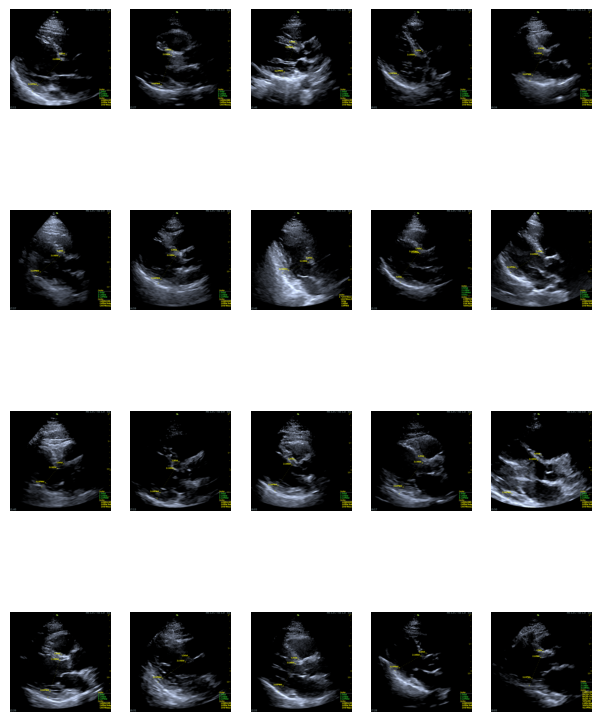

In [ ]:
#visualizción
fig, axes = plt.subplots(4, 5, figsize=(1.5*5,2*5))
for i in range(20):
    ax = axes[i//5, i%5]
    ax.imshow(im_array[i])
    ax.axis('off')
plt.show()

In [ ]:
#cargo las medidas (seran los targets en mi modelo)
'''las medidas fueron extraidas a mano de las imagenes sin crop, como se ve en el primer ejemplo'''

medidas=pd.read_csv('/content/drive/MyDrive/portfolio/trabajo final borrador/Libro.csv',sep=';')



# Análisis exploratorio de Datos

# Preparación de datos

In [ ]:
# exploracion de Targets
medidas.head()

,siv,ddvi,pp
0,6.30,48.50,7.0
1,8.80,55.00,9.0
2,9.50,43.60,10.0
3,14.00,33.65,10.0
4,10.66,42.80,10.0


In [ ]:
#no hay valores faltantes
medidas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   siv     154 non-null    float64
 1   ddvi    154 non-null    float64
 2   pp      154 non-null    float64
dtypes: float64(3)
memory usage: 3.7 KB


array([[<Axes: title={'center': 'siv'}>,
        <Axes: title={'center': 'ddvi'}>],
       [<Axes: title={'center': 'pp'}>, <Axes: >]], dtype=object)

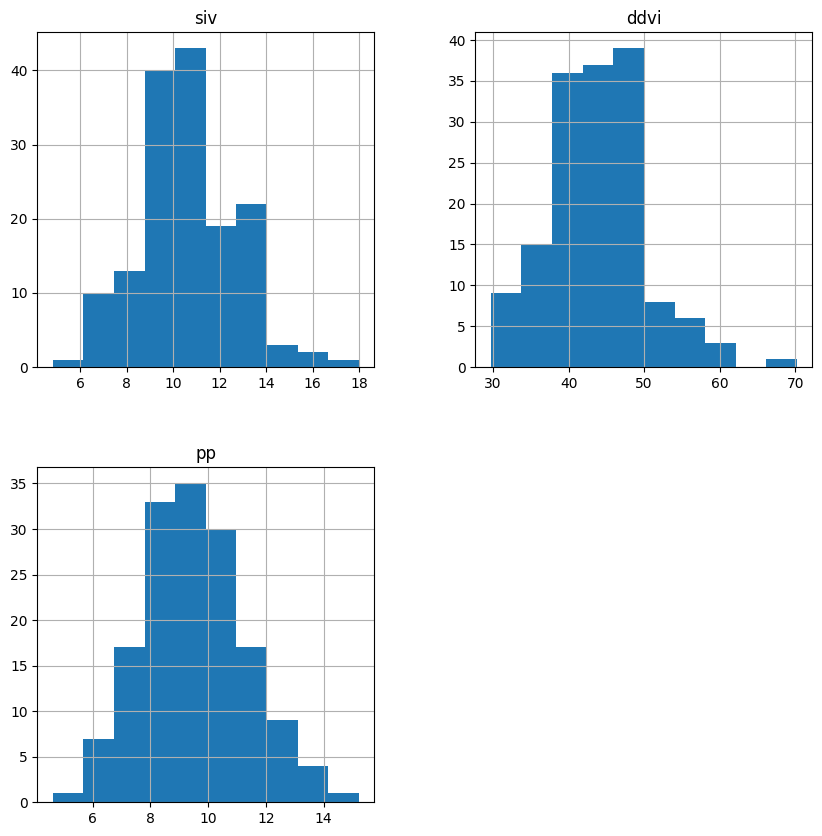

In [ ]:
medidas.hist(figsize=(10,10))

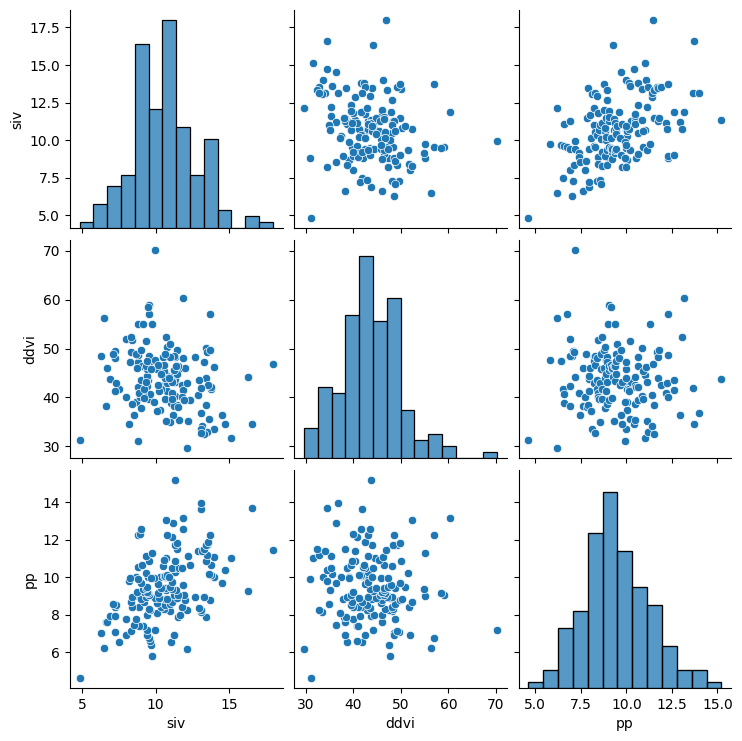

In [ ]:
sns.pairplot(medidas)

Como era de esperarse existe una relación entre los espesores de ambas paredes, tanto así con ddvi.

In [ ]:
medidas.describe()

,siv,ddvi,pp
count,154.000000,154.000000,154.000000
mean,10.623961,43.759221,9.474545
std,2.148459,6.416908,1.812063
min,4.820000,29.680000,4.620000
25%,9.210000,39.717500,8.310000
50%,10.615000,43.470000,9.285000
75%,11.792500,47.655000,10.595000
max,18.000000,70.240000,15.220000


Las variables son prácticamente normales, el valor extremos de 70mm es biológicamente plausible.

# Generación de los modelos

Se va a realizar un modelo utilizando una CNN generada manualmente. Ese modelo se pasara a CHAT GPT y se solicitaran mejoras para optimizar MAE. Se entrenará un nuevo modelo. Luego se intentará un trasfer learning con Resnet, luego una nueva optimización con CHAT GPT. Se graficarán los MAE en función del modelo para seleccionar el que mejor realice las mediciones.

## Red multicapa generada manualmente

In [ ]:
Y=medidas.to_numpy()

### Modelo manual

In [ ]:
datagen = ImageDataGenerator(
    validation_split=0.2,
    vertical_flip=True,
    horizontal_flip=True,
    rotation_range=60,        # roto imagenes
    width_shift_range=0.2,    # shift de imagenes
    height_shift_range=0.2,
    shear_range=0.15,         # deforamcion
    zoom_range=0.2,           # Zoom in y out 20%
    brightness_range=[0.8, 1.2], # cambio brillo
    fill_mode='nearest'
)

In [ ]:
#divido en train y en test
x_train,x_test,y_train,y_test=train_test_split(np.array(im_array),Y, train_size=0.8,shuffle=True,random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(123, 224, 224, 3)
(31, 224, 224, 3)
(123, 3)
(31, 3)


In [ ]:
model = Sequential()

# Primera capa de convolución y batch normalization
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Segunda capa de convolución con max pooling y dropout
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Tercera capa de convolución con batch normalization
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Cuarta capa de convolución con max pooling y dropout
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Quinta capa de convolución con batch normalization
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Sexta capa de convolución con max pooling y dropout
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Clasificación final
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(3, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,158,707 (19.68 MB)

 Trainable params: 5,158,067 (19.68 MB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
start_time=time.time()
history= model.fit(
    datagen.flow(x_train,y_train,batch_size=3,subset='training',seed=7,shuffle=True,ignore_class_split=True),
    validation_data=datagen.flow(x_train,y_train,batch_size=8,subset='validation',seed=7,shuffle=True,ignore_class_split=True),
    steps_per_epoch=len(x_train)//32, epochs=50
)
end_time=time.time()
print(f'tiempo de entrenamiento: {start_time-end_time}')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 851.2488 - mae: 22.3081 - val_loss: 717.4431 - val_mae: 21.4216
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 293.6645 - mae: 14.5755 - val_loss: 690.0158 - val_mae: 20.9325
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 308.1281 - mae: 12.3450 - val_loss: 579.5521 - val_mae: 18.8829
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 401.7467 - mae: 16.2722 - val_loss: 551.4034 - val_mae: 18.4237
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 82.2291 - mae: 7.1216 - val_loss: 514.1924 - val_mae: 17.7453
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step - loss: 291.9853 - mae: 12.3485 - val_loss: 461.7384 - val_mae: 16.7128
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 221.9497 - mae: 10.4597 - val_loss: 377.7725 - val_mae: 14.9576
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 173.0028 - mae: 9.4149 - val_loss: 320.8397 - val_mae: 13.7163
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - val_loss: 225.5322 - val_mae: 11.6906
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step - loss: 77.2370 - mae: 7.5345 - val_loss: 193.5260 - val_mae: 10.7006
Epoch 14/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - loss: 112.5300 - mae: 7.1148 - val_loss: 198.3470 - val_mae: 10.8149
Epoch 15/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step - loss: 252.7517 - mae: 11.3332 - val_loss: 204.5785 - val_mae: 11.0671
Epoch 16/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step - loss: 768.8590 - mae: 16.8485 - val_loss: 193.2389 - val_mae: 10.7277
Epoch 17/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - loss: 166.9611 - mae: 8.9479 - val_loss: 166.2402 - val_mae: 9.8288
Epoch 18/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - loss: 208.3578 - mae: 11.1355 - val_loss: 142.9826 - val_mae: 9.1066
Epoch 19/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step - loss: 143.9775 - mae: 8.4794 - val_loss: 124.5419 - val_mae: 8.4603
Epoch 20/50
3/3 ━━━━━━━━━━━━━━━

In [ ]:
y_pred=model.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [ ]:
y_pred[0:5]

array([[ 1.8053949 ,  7.5915303 ,  2.3117976 ],
       [ 7.601115  , 24.723837  ,  7.6623034 ],
       [ 0.93486327,  9.792642  ,  4.4424295 ],
       [-0.26321164,  3.8236878 , -0.72431636],
       [ 4.759683  , 15.129663  ,  5.2945724 ]], dtype=float32)

In [ ]:
y_test[0:5]

array([[11.3 , 43.11, 10.27],
       [12.14, 42.88,  8.22],
       [ 8.24, 47.25,  9.97],
       [ 7.33, 42.96,  8.53],
       [ 9.2 , 41.8 ,  8.66]])

In [ ]:
# Creo un diccionario para guardar las metricas
metricas = {}
#defino funcion para los mae y graficar

def graficar_mae_history(history):
    mae = history.history['mae']
    val_mae = history.history['val_mae']
    epochs = range(1, len(mae) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, mae, 'b', label='Training MAE')
    plt.plot(epochs, val_mae, 'r', label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()
def mae_test(y_test,y_pred):
  mae_siv=mean_absolute_error(y_test[:,0],y_pred[:,0])
  mae_ddvi=mean_absolute_error(y_test[:,1],y_pred[:,1])
  mae_pp=mean_absolute_error(y_test[:,2],y_pred[:,2])
  mae_global=mean_absolute_error(y_test,y_pred)
  return mae_siv,mae_ddvi,mae_pp,mae_global
def graficar_test_pred(y_test,y_pred):
  for ind,feature in enumerate(['SIV','DDVI','PP']):
    plt.figure(figsize=(10,6))
    plt.scatter(range(len(y_test)), y_test[:, ind], label=f'y_test {feature}', color='blue')
    plt.scatter(range(len(y_test)), y_pred[:, ind], label=f'y_pred {feature}', color='red')
    plt.xlabel('Sample Index')
    plt.ylabel(f'{feature}')
    plt.legend()
    plt.show()


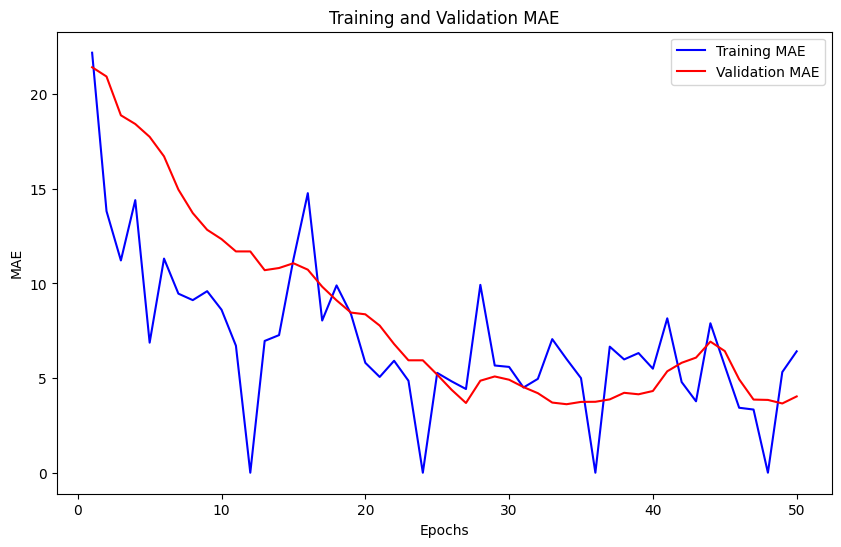

In [ ]:
graficar_mae_history(history)

In [ ]:
metricas['modelomanual']={}
metricas['modelomanual']['mae_siv'],metricas['modelomanual']['mae_ddvi'],metricas['modelomanual']['mae_pp'],metricas['modelomanual']['mae_global']=mae_test(y_test,y_pred)
for k,v in metricas['modelomanual'].items():
  print(k,v)

mae_siv 7.394545076470222
mae_ddvi 30.923906982944864
mae_pp 5.393545461931535
mae_global 14.570665840448875


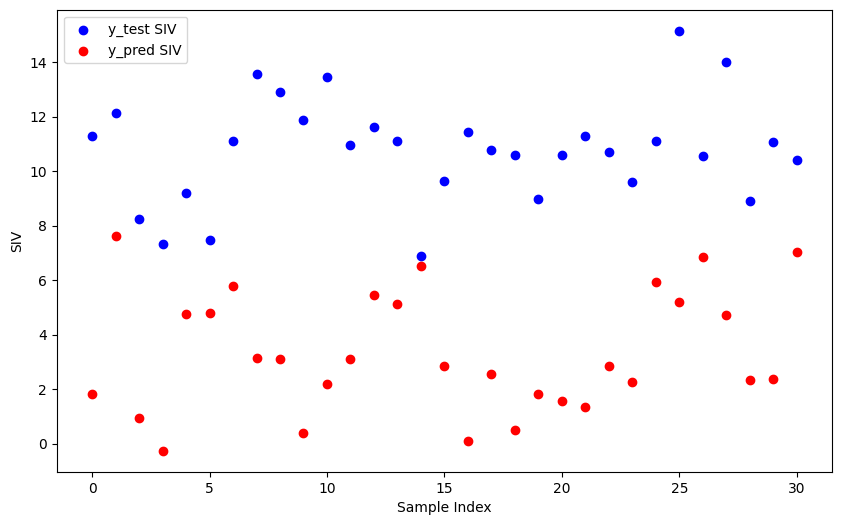

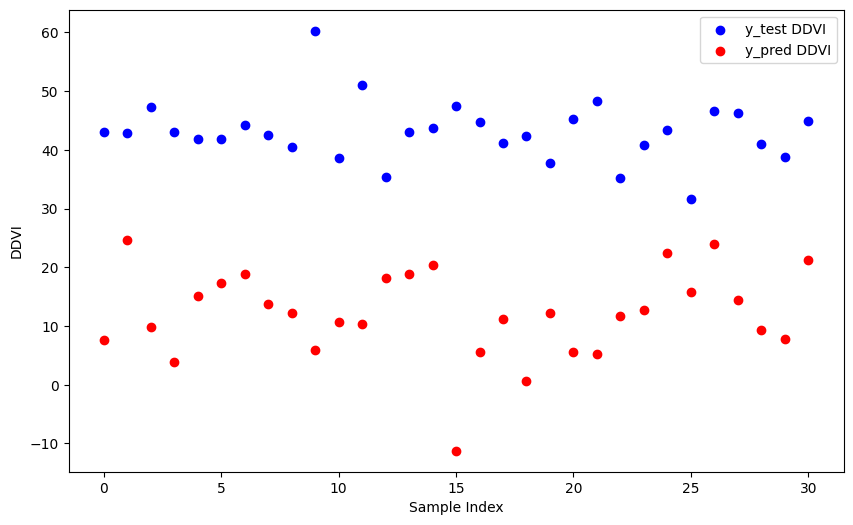

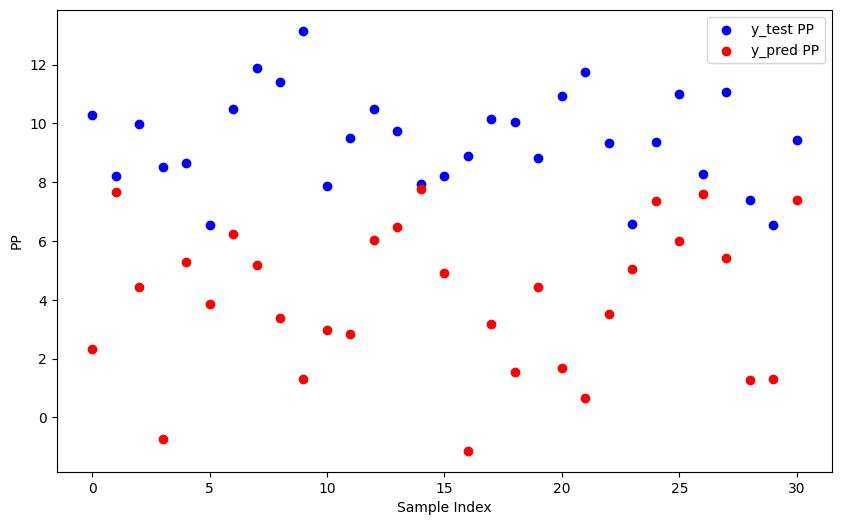

In [ ]:
graficar_test_pred(y_test,y_pred)

### Nuevo modelo con sugerencias chat gpt

In [ ]:

# Define the model
model = Sequential()

# First Convolutional Block
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))  # Reduced dropout

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))  # Reduced dropout

# Third Convolutional Block
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Fourth Convolutional Block
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Final Classification Block
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))  # Added L2 regularization
model.add(Dropout(0.4))  # Increase dropout for the dense layer to prevent overfitting
model.add(Dense(3, activation='linear'))

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)  # Reduced learning rate
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

# Measure training time
start_time = time.time()
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=16, subset='training', seed=7, shuffle=True, ignore_class_split=True),
    validation_data=datagen.flow(x_train, y_train, batch_size=16, subset='validation', seed=7, shuffle=True, ignore_class_split=True),
    steps_per_epoch=len(x_train) // 16, epochs=100,  # Increased epochs
)
end_time = time.time()
print(f'Training time: {end_time - start_time} seconds')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 56, 56, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,059,011 (26.93 MB)

 Trainable params: 7,058,307 (26.93 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 904.5341 - mae: 22.3324 - val_loss: 718.5607 - val_mae: 21.4712
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - val_loss: 718.4807 - val_mae: 21.4697
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 838.4742 - mae: 21.6215 - val_loss: 668.7516 - val_mae: 20.7092
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - val_loss: 669.6608 - val_mae: 20.7209
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 580.4991 - mae: 17.4573 - val_loss: 603.0953 - val_mae: 19.6425
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - val_loss: 604.5865 - val_mae: 19.6616
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 405.6736 - mae: 14.4885 - val_loss: 510.2783 - val_mae: 17.9772
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - val_loss: 510.0716 - val_mae: 17.9736
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 260.0600 - mae: 11.3065 - val_loss: 394.6827 - val_mae: 15.7118
Epoch 10/100
7/7

In [ ]:
y_pred=model.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
y_pred[0:5]

array([[ 2.0958657,  8.359313 ,  3.619797 ],
       [ 1.3662717,  3.8402545,  1.6167852],
       [ 1.8877659,  7.945703 ,  2.355527 ],
       [ 2.971631 , 10.296273 ,  2.764117 ],
       [ 1.2609754,  6.1543508,  2.3192997]], dtype=float32)

In [ ]:
y_test[0:5]

array([[11.3 , 43.11, 10.27],
       [12.14, 42.88,  8.22],
       [ 8.24, 47.25,  9.97],
       [ 7.33, 42.96,  8.53],
       [ 9.2 , 41.8 ,  8.66]])

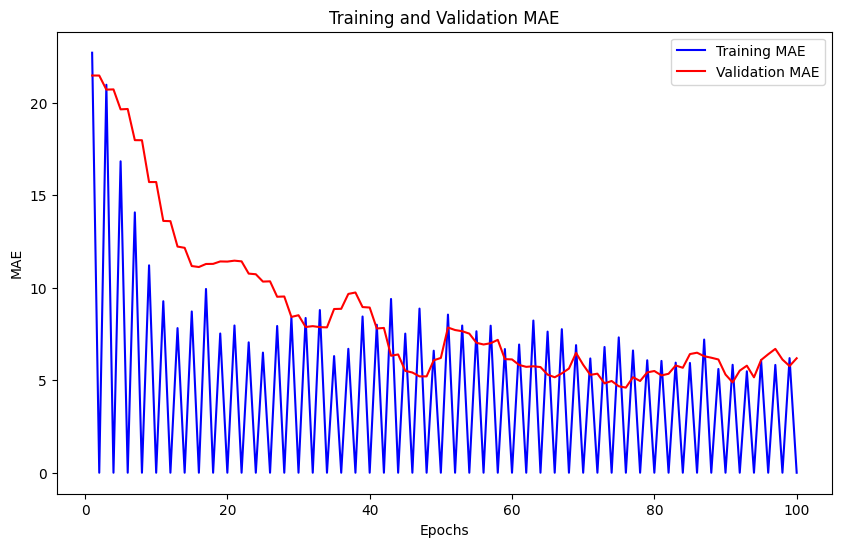

In [ ]:
graficar_mae_history(history)

In [ ]:
metricas['modelomanual_gpt']={}
metricas['modelomanual_gpt']['mae_siv'],metricas['modelomanual_gpt']['mae_ddvi'],metricas['modelomanual_gpt']['mae_pp'],metricas['modelomanual_gpt']['mae_global']=mae_test(y_test,y_pred)
for k,v in metricas['modelomanual_gpt'].items():
  print(k,v)

mae_siv 8.594268326913156
mae_ddvi 35.346438822284824
mae_pp 7.043516458695934
mae_global 16.994741202631307


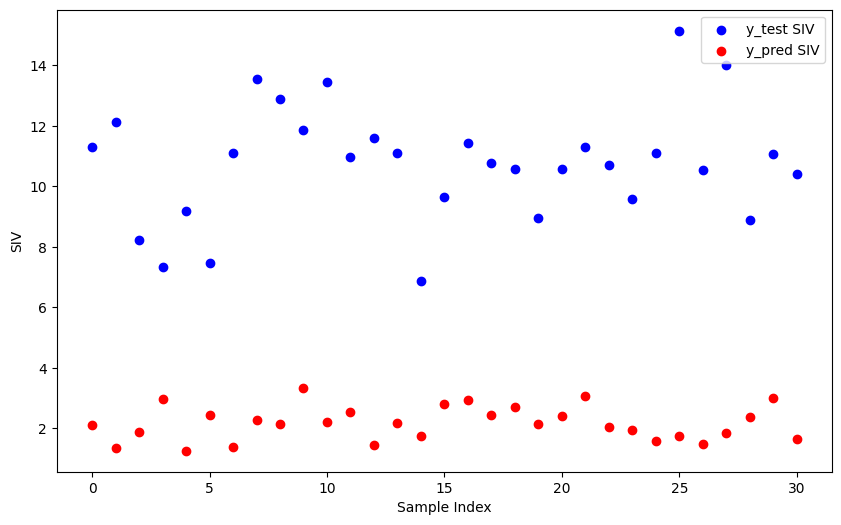

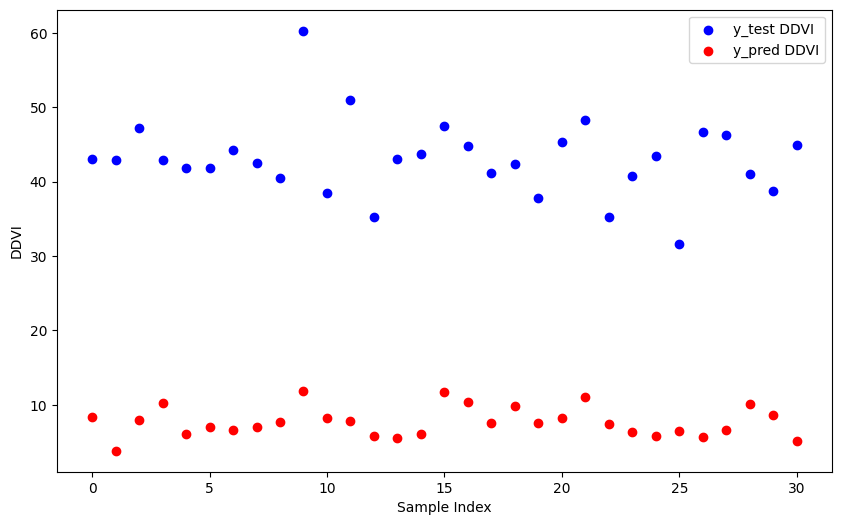

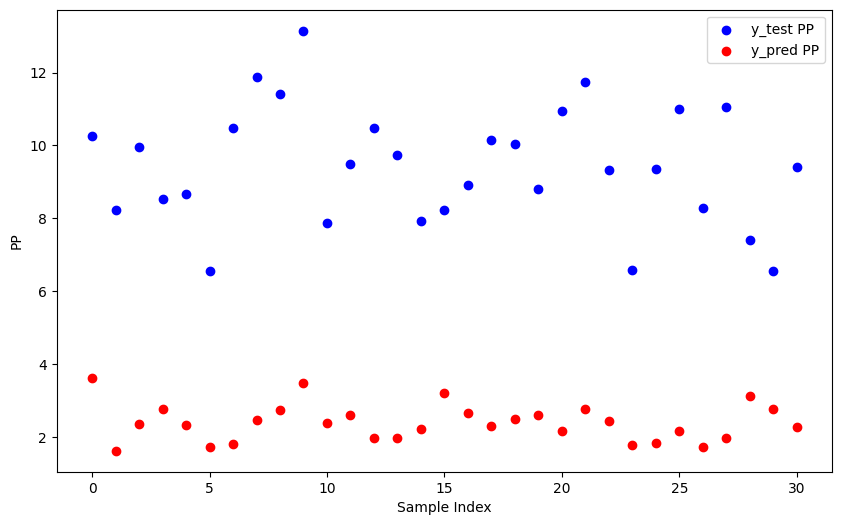

In [ ]:
graficar_test_pred(y_test,y_pred)

In [ ]:

test_loss, test_mae = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step - loss: 467.6303 - mae: 16.9947
Test Loss: 467.6303405761719
Test MAE: 16.994741439819336


## Transfer learning RESNET

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=x_train.shape[1:])
base_model.trainable = False  # Freeze the ResNet50 base layers

# Define the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3)  # Output layer with 3 neurons for three measurements
])

# Compile the model with Mean Squared Error loss, suitable for regression
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=16, subset='training', seed=7, shuffle=True, ignore_class_split=True),
    validation_data=datagen.flow(x_train, y_train, batch_size=16, subset='validation', seed=7, shuffle=True, ignore_class_split=True),
    epochs=20
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 655.0815 - mae: 20.3253 - val_loss: 502.0977 - val_mae: 17.9682
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 462.1053 - mae: 16.8296 - val_loss: 343.5381 - val_mae: 14.4732
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 290.2311 - mae: 12.9204 - val_loss: 207.9553 - val_mae: 10.8960
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 184.6826 - mae: 10.1630 - val_loss: 105.8664 - val_mae: 7.8652
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 85.7159 - mae: 7.2316 - val_loss: 41.8378 - val_mae: 4.6851
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 39.0046 - mae: 4.4247 - val_loss: 16.4495 - val_mae: 2.8473
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 22.6848 - mae: 3.2612 - val_loss: 16.4165 - val_mae: 3.0213
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 19.3322 - mae: 3.0514 - val_loss: 19.6618 - val_mae: 3.2453
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss:

In [ ]:
y_pred=model.predict(x_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [ ]:
y_pred[0:5]

array([[11.603121, 48.14487 , 10.329721],
       [10.751089, 44.36331 ,  9.557751],
       [11.36157 , 47.014786, 10.093639],
       [11.594965, 48.106007, 10.319721],
       [11.346262, 46.987724, 10.097097]], dtype=float32)

In [ ]:
y_test[0:5]

array([[11.3 , 43.11, 10.27],
       [12.14, 42.88,  8.22],
       [ 8.24, 47.25,  9.97],
       [ 7.33, 42.96,  8.53],
       [ 9.2 , 41.8 ,  8.66]])

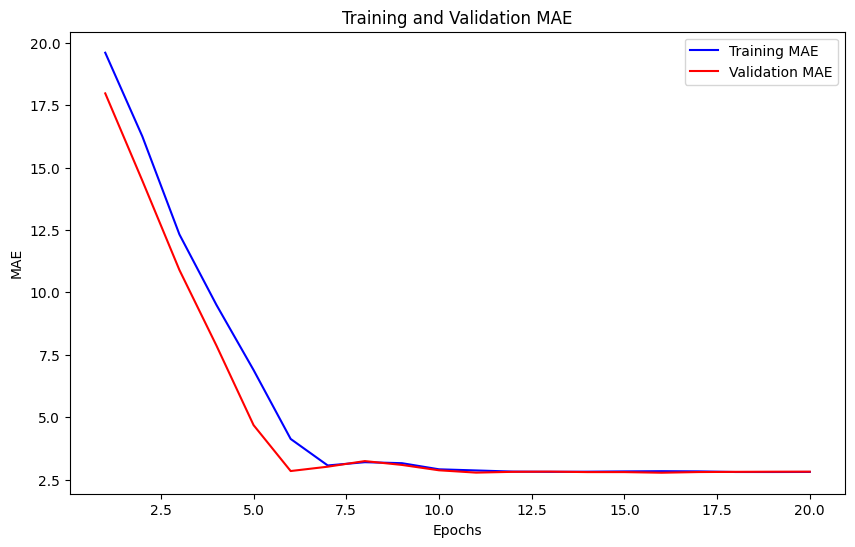

In [ ]:
graficar_mae_history(history)

In [ ]:
metricas['res']={}
metricas['res']['mae_siv'],metricas['res']['mae_ddvi'],metricas['res']['mae_pp'],metricas['res']['mae_global']=mae_test(y_test,y_pred)
for k,v in metricas['res'].items():
  print(k,v)

mae_siv 1.4841407578991306
mae_ddvi 4.588212142452116
mae_pp 1.3510660319174488
mae_global 2.474472977422899


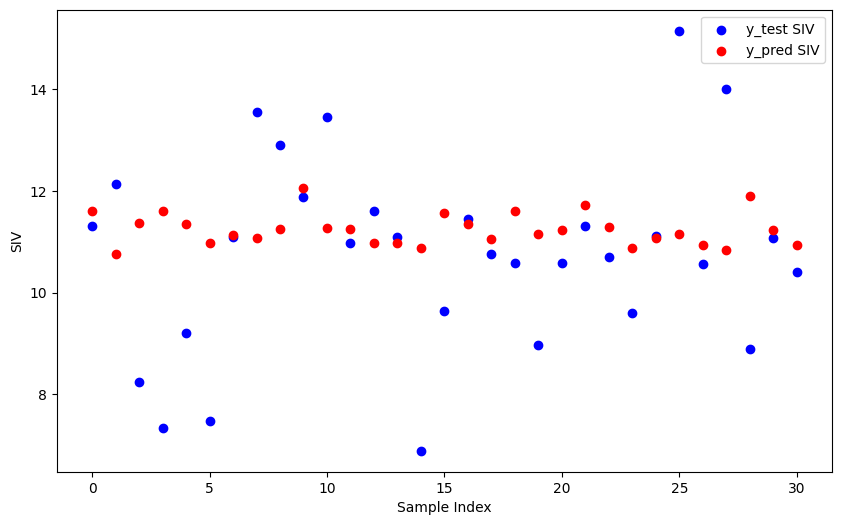

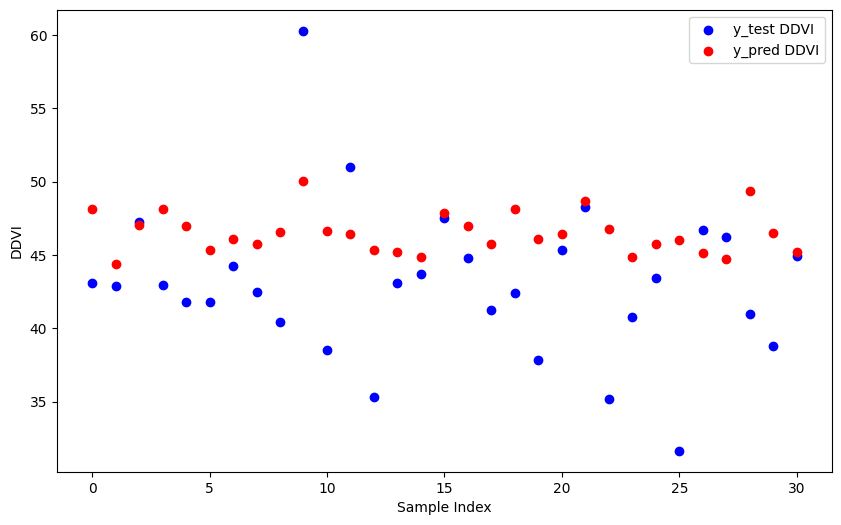

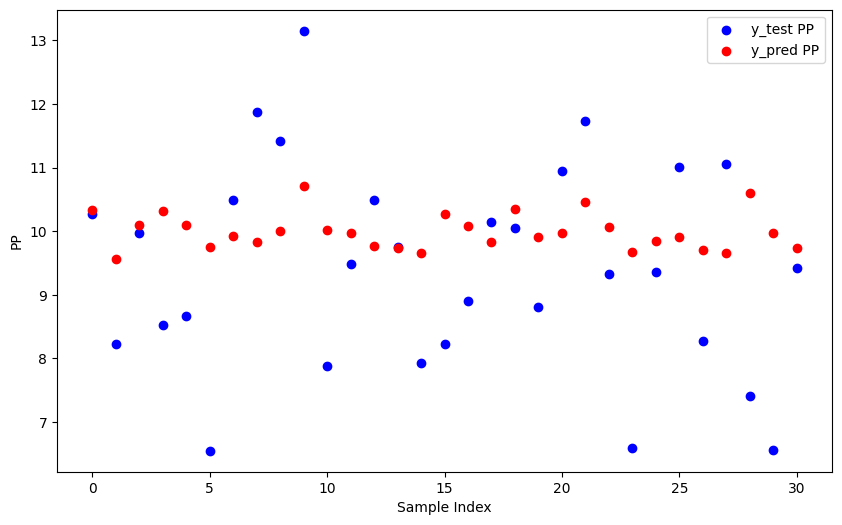

In [ ]:
graficar_test_pred(y_test,y_pred)

### Matríz de confusión para ver consecuencias clínicas de los errores del mejor modelo
Esta sección debe verse al finalizar el analisis de los modelos. Sin embargo, la puse más arriba para que pueda correse toda la notebook y que no se modifique la salida del codigo. Ya el último modelo es el de restnet modificado y no es el mejor.

para correr esta sección debe utilizarce este modelo
resnet20epocs.h5



In [ ]:
medidas.head()

,siv,ddvi,pp
0,6.30,48.50,7.0
1,8.80,55.00,9.0
2,9.50,43.60,10.0
3,14.00,33.65,10.0
4,10.66,42.80,10.0


In [ ]:
#estudios considerados normales
#se considerará estudio anormal cualquiera que sea >= a las siguientes medidas
normalidad={'ddvi':59,'pp':10,'siv':13}
medidas['ddvi_normal']=medidas['ddvi']<normalidad['ddvi']
medidas['pp_normal']=medidas['pp']<normalidad['pp']
medidas['siv_normal']=medidas['siv']<normalidad['siv']
medidas['normal']=medidas['ddvi_normal']&medidas['pp_normal']&medidas['siv_normal']


In [ ]:
y_pred=model.predict(np.array(im_array))



4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


array([[10.763729 , 46.55577  ,  9.857197 ],
       [10.5306225, 45.583813 ,  9.675957 ],
       [11.489685 , 49.801147 , 10.594507 ],
       [10.653303 , 46.135715 ,  9.792921 ],
       [10.380186 , 44.935722 ,  9.539713 ],
       [10.311811 , 44.657654 ,  9.474936 ],
       [10.630865 , 46.004578 ,  9.77121  ],
       [10.697763 , 46.32386  ,  9.830179 ],
       [10.482168 , 45.35988  ,  9.631981 ],
       [11.164911 , 48.34451  , 10.265171 ],
       [10.564951 , 45.77353  ,  9.712393 ],
       [10.680929 , 46.188896 ,  9.809019 ],
       [10.596563 , 45.83969  ,  9.701257 ],
       [10.645943 , 46.09856  ,  9.796373 ],
       [11.411123 , 49.372208 , 10.484104 ],
       [11.15405  , 48.375156 , 10.272253 ],
       [10.983002 , 47.588593 , 10.125078 ],
       [10.993797 , 47.607742 , 10.128852 ],
       [10.675841 , 46.20004  ,  9.820015 ],
       [10.496347 , 45.42534  ,  9.638161 ],
       [10.627565 , 45.96934  ,  9.757486 ],
       [10.903396 , 47.270264 , 10.065147 ],
       [10

In [ ]:
medidas['ss_pred'],medidas['ddvi_pred'],medidas['pp_pred']=y_pred[:,0],y_pred[:,1],y_pred[:,2]
medidas['ddvi_pred_normal']=medidas['ddvi_pred']<normalidad['ddvi']
medidas['pp_pred_normal']=medidas['pp_pred']<normalidad['pp']
medidas['siv_pred_normal']=medidas['ss_pred']<normalidad['siv']
medidas['pred_normal']=medidas['ddvi_pred_normal']&medidas['pp_pred_normal']&medidas['siv_pred_normal']


In [ ]:
medidas.head()

,siv,ddvi,pp,ddvi_normal,pp_normal,siv_normal,normal,ss_pred,ddvi_pred,pp_pred,ddvi_pred_normal,pp_pred_normal,siv_pred_normal,pred_normal
0,6.30,48.50,7.0,True,True,True,True,10.763729,46.555771,9.857197,True,True,True,True
1,8.80,55.00,9.0,True,True,True,True,10.530622,45.583813,9.675957,True,True,True,True
2,9.50,43.60,10.0,True,False,True,False,11.489685,49.801147,10.594507,True,False,True,False
3,14.00,33.65,10.0,True,False,False,False,10.653303,46.135715,9.792921,True,True,True,True
4,10.66,42.80,10.0,True,False,True,False,10.380186,44.935722,9.539713,True,True,True,True


Confusion Matrix:
[[19 17]
 [47 71]]

Classification Report:
              precision    recall  f1-score   support

     Anormal       0.29      0.53      0.37        36
      Normal       0.81      0.60      0.69       118

    accuracy                           0.58       154
   macro avg       0.55      0.56      0.53       154
weighted avg       0.69      0.58      0.62       154



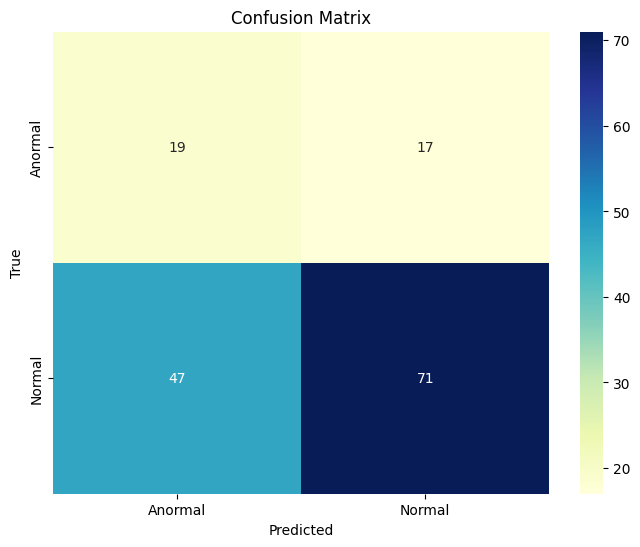

In [ ]:
# prompt: create confusion matrix between medidas.pred_normal and medidas.normal
# calculate metrics
# change 1 label to 'Normal'
# change 0 label to 'Anormal'
# use different pallete

from sklearn.metrics import confusion_matrix, classification_report

# Create the confusion matrix
cm = confusion_matrix(medidas.pred_normal, medidas.normal)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate and print classification metrics
cr = classification_report(medidas.pred_normal, medidas.normal, target_names=['Anormal', 'Normal'])
print("\nClassification Report:")
print(cr)

# Visualize the confusion matrix using seaborn
labels = ['Anormal', 'Normal']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### RESNET + CHAT GPT

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
#genero early stopping para optomizar computo
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
#lr scheduler para el mejor learning rate
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
for layer in base_model.layers[-10:]:  # descongelo capas
    layer.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3)
])

# adam con perdida de huber
model.compile(optimizer='adam', loss='huber', metrics=['mae'])

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=16, subset='training', seed=7, shuffle=True, ignore_class_split=True),
    validation_data=datagen.flow(x_train, y_train, batch_size=16, subset='validation', seed=7, shuffle=True, ignore_class_split=True),
    epochs=50,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 18.2563 - mae: 18.7533 - val_loss: 12.6415 - val_mae: 13.1294 - learning_rate: 0.0010
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - loss: 11.5789 - mae: 12.0678 - val_loss: 31.2035 - val_mae: 31.7035 - learning_rate: 0.0010
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 6.8232 - mae: 7.3146 - val_loss: 42.2103 - val_mae: 42.7103 - learning_rate: 0.0010
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 4.1912 - mae: 4.6632
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 4.2052 - mae: 4.6773 - val_loss: 38.7495 - val_mae: 39.2495 - learning_rate: 0.0010
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 4.5654 - mae: 5.0362 - val_loss: 24.6749 - val_mae: 25.1749 - learning_rate: 5.0000e-04
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - loss: 4.7353 - mae: 5.2154 - val_loss: 17.6937 - val_mae: 18.1937 - learning_rate: 5.0000e-04
Epoch

In [ ]:
y_pred=model.predict(x_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [ ]:
y_pred[0:5]

array([[15.751572, 25.122711, 26.9875  ],
       [14.570593, 23.19617 , 25.02607 ],
       [15.260834, 24.347534, 26.151104],
       [15.651434, 24.943027, 26.771297],
       [15.305489, 24.386467, 26.218075]], dtype=float32)

In [ ]:
y_test[0:5]

array([[11.3 , 43.11, 10.27],
       [12.14, 42.88,  8.22],
       [ 8.24, 47.25,  9.97],
       [ 7.33, 42.96,  8.53],
       [ 9.2 , 41.8 ,  8.66]])

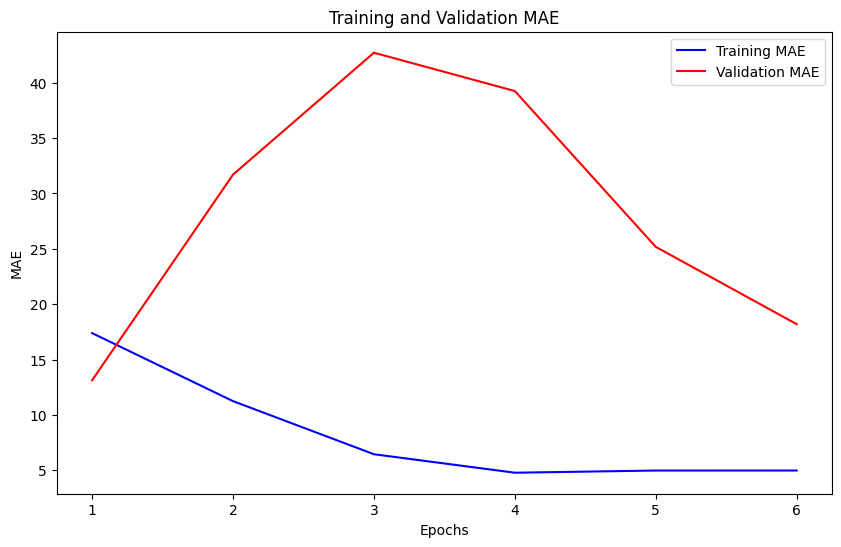

In [ ]:
graficar_mae_history(history)

In [ ]:
metricas['res_gpt']={}
metricas['res_gpt']['mae_siv'],metricas['res_gpt']['mae_ddvi'],metricas['res_gpt']['mae_pp'],metricas['res_gpt']['mae_global']=mae_test(y_test,y_pred)
for k,v in metricas['res_gpt'].items():
  print(k,v)

mae_siv 4.4375002104236225
mae_ddvi 18.835777243337322
mae_pp 16.634432877571353
mae_global 13.3025701104441


In [ ]:
metricas_=pd.DataFrame(metricas).T.reset_index().rename(columns={'index':'modelo'})
metricas

,modelo,mae_siv,mae_ddvi,mae_pp,mae_global
0,modelomanual,7.394545,30.923907,5.393545,14.570666
1,modelomanual_gpt,8.594268,35.346439,7.043516,16.994741
2,res,1.484141,4.588212,1.351066,2.474473
3,res_gpt,4.437500,18.835777,16.634433,13.302570


# Conclusiones

En base a la cantidad de datos suministrados se pudo obtener un modelo que fue capaz de predecir las dimensiones del vetrículo izquierdo. El mejor modelo fue RESNET. Complejizar el modelo según chat gpt solamente trajo más errores en las estimaciones. De hecho, RESNET con 20 EPOCHS parecería ser suficiente para obtener resultados semejantes a 50 EPOCHS

A pesar de que el error absoluto fue de 2.47 global y de 1.5mm, 4.6mm y 1.35mm para SIV, DDVI y PP, esta falta de precisión es clínicamente relevante, ya que podría clasificar dimensiones normales como patológicas o viceversa.

Si  consideramos un estudio anormal como la presencia de cualquiera de las tres mediciones por fuera del rango de la normalidad. Las predicciones del mejor modelo llevó a que 47 estudios normales fueran clasificados como patológicos y 17 patológicos como normales.

Es por esto que, previo a su implementación en la práctica clínica, deba mejorarse la presición del modelo. Tal vez, incorporando mayor número de ejemplos podría llegarse a un error no significativo, que debería ser menor 1mm.

Para concluir, la generación de un modelo con esta cantidad acotada de ejemplos fue posible con un error absoluto en la predicciones bajo. El modelo tubo particularmente dificultades para predecir DDVI. A pesar del bajo error, este es clínicamente relevante y debe disminuirse antes de poder ser implementado en la práctica clínica.

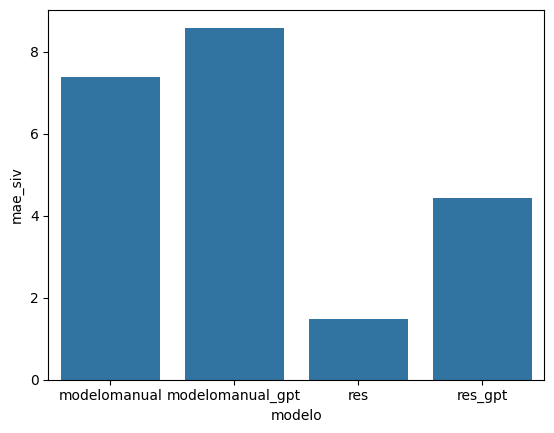

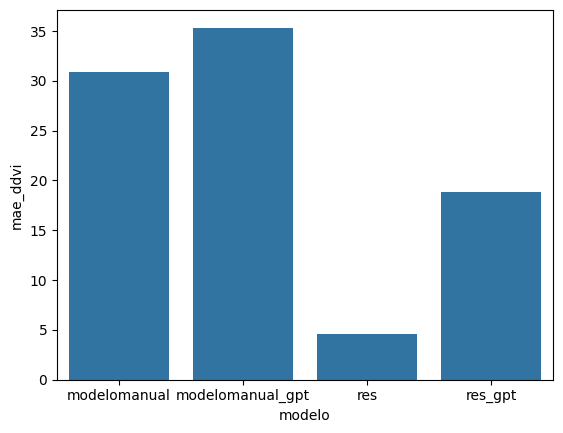

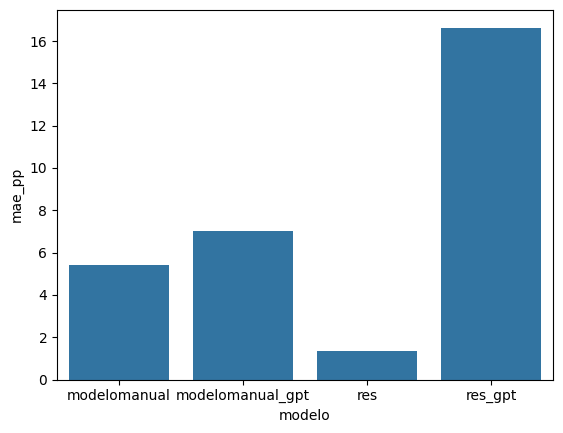

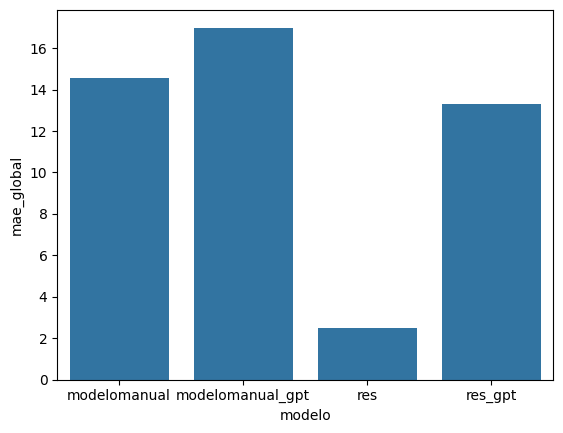

In [ ]:
for i in metricas.columns[1:]:
  sns.barplot(data=metricas,x='modelo',y=i)
  plt.show()
#sns.barplot(data=metricas,x='modelo',y='mae_global')